# Analysis

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

# data
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# viz
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
SQL_USERNAME = "postgres"
SQL_PASSWORD = "postgres"
SQL_IP = "localhost"
PORT = 5432
DATABASE = "crowdfunding_db"

In [3]:
connection_string = f"postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{PORT}/{DATABASE}"
engine = create_engine(connection_string)

In [4]:
# INSPECT
# explore and understand the data

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within each table and its types
for table in tables:
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
        
    print()

contacts
contact_id INTEGER
first_name VARCHAR(12)
last_name VARCHAR(13)
email VARCHAR(42)

campaign
cf_id INTEGER
contact_id INTEGER
company_name VARCHAR(33)
description VARCHAR(53)
goal DOUBLE PRECISION
pledged DOUBLE PRECISION
outcome VARCHAR(10)
backers_count INTEGER
country VARCHAR(2)
currency VARCHAR(3)
launch_date DATE
end_date DATE
category_id VARCHAR(4)
subcategory_id VARCHAR(8)

category
category_id VARCHAR(4)
category VARCHAR(12)

subcategory
subcategory_id VARCHAR(8)
subcategory VARCHAR(17)



In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
Base.classes.keys()

['contacts', 'category', 'campaign', 'subcategory']

In [6]:
# Assign the classes to variables
Camp = Base.classes.campaign
subCat = Base.classes.subcategory
Co = Base.classes.contacts
Cat = Base.classes.category

In [7]:
session = Session(engine)

# Questions

# Question 1: What crowdfunding campaign categories are most successful?

In [8]:
# We need outcome from campaign 
# AND category from category on the foreign key category_id
# ORM query
query = session.query(
    Camp.outcome,
    Cat.category
).join(
    Cat,
    Cat.category_id == Camp.category_id
)

# fetch the results and put in dataframe
results = query.all()
df = pd.DataFrame(results)
df

,outcome,category
0,failed,food
1,successful,music
2,successful,technology
3,failed,music
4,failed,theater
...,...,...
995,successful,food
996,failed,theater
997,canceled,theater
998,failed,music


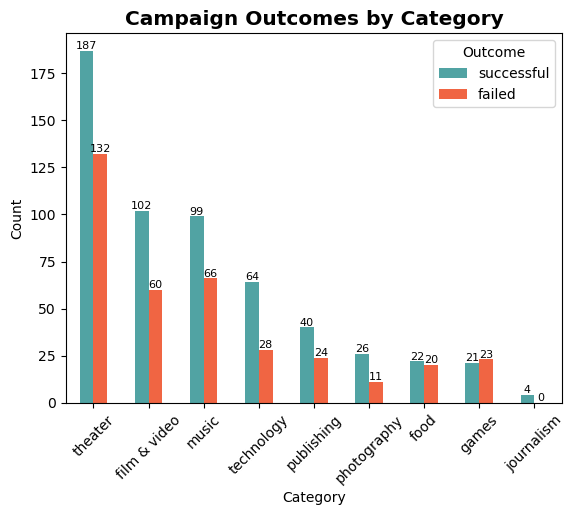

In [9]:
# Calculate total successful counts for each category and sort categories descending
pg = df.groupby(["category", "outcome"])["category"].count().unstack("outcome")
pg_sorted = pg.sort_values(by='successful', ascending=False)

# Plotting
ax = pg_sorted[["successful", "failed"]].plot(kind="bar", color=["#51A3A3", "#F06543"])
plt.title("Campaign Outcomes by Category", fontweight="bold", fontsize=14.5)
for container in ax.containers:
    ax.bar_label(container, size=8)
plt.legend(title='Outcome')
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# Question #2: What is the relationship between the backers count and the amount pledged? (only USD)

In [10]:
# We need backers_count, pledged and currency from campaign
# WHERE currency is USD
# ORM query
query = session.query(
    Camp.backers_count,
    Camp.pledged,
    Camp.currency
).filter(
    Camp.currency == 'USD'
)

# fetch the results and put in dataframe
results = query.all()
df = pd.DataFrame(results)
df

,backers_count,pledged,currency
0,158,14560.0,USD
1,24,2477.0,USD
2,53,5265.0,USD
3,44,3208.0,USD
4,220,13838.0,USD
...,...,...,...
758,842,74073.0,USD
759,2043,153216.0,USD
760,112,4814.0,USD
761,374,37823.0,USD


y = 41.89x + 11218.62
The r-squared is: 0.7496992378033818


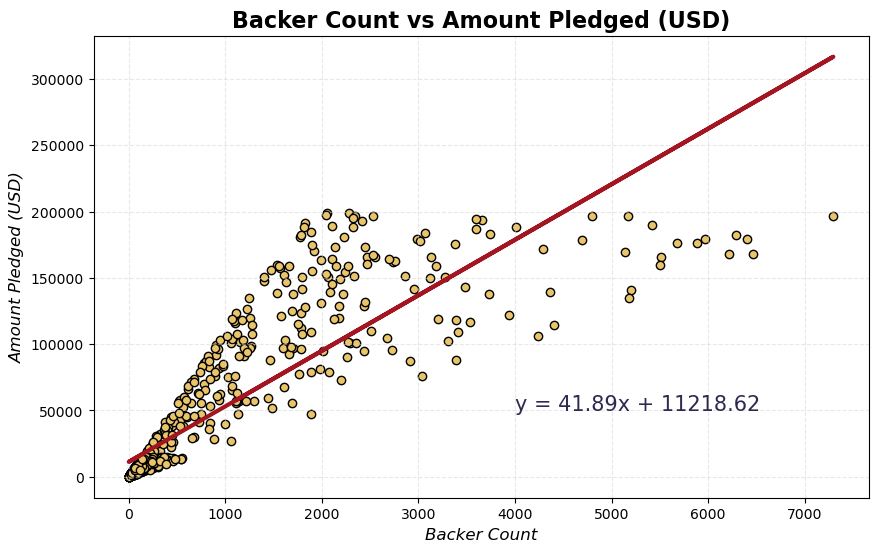

In [11]:
# plot data
x_values = df.backers_count
y_values = df.pledged

# makes the line of best fit
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)

# make the plot
# Step 2: Make the canvas
plt.figure(figsize=(10, 6))

# Step 3: Make the basic plot
plt.scatter(x_values, y_values, facecolor="#e9c46a", edgecolor="black")
plt.plot(x_values, regress_values, "#A31621", linewidth=3)

# Step 4: Customizations
plt.xlabel("Backer Count", fontsize=12, fontstyle="italic")
plt.ylabel("Amount Pledged (USD)", fontsize=12, fontstyle="italic")
plt.title("Backer Count vs Amount Pledged (USD)", fontweight="bold", fontsize=16)
plt.grid(color="lightgrey", linestyle = "--", alpha=0.5)


plt.annotate(line_eq,(4000, 50000),fontsize=15,color="#2E294E")

print(f"The r-squared is: {rvalue**2}")
plt.show()

# Question #3: What is the relation of the outcomes based on goal amounts in USD. (split violin plot)


In [12]:
# We need outcome, goal, and currency in campaign
# AND category from category on the foreign key category_id
# WHERE currency is USD
# AND outcome is only either successful or failed
# AND category is either theater, film & video, music, or technology

# ORM query
query = session.query(
    Camp.outcome,
    Cat.category,
    Camp.goal,
    Camp.currency
).join(
    Cat,
    Cat.category_id == Camp.category_id,
    isouter=True
).filter(
    Camp.currency == 'USD',
    Cat.category.in_(['theater', 'film & video', 'music', 'technology']),
    Camp.outcome.in_(['successful', 'failed'])
)

# fetch the results and put in dataframe
results = query.all()
df = pd.DataFrame(results)
df

,outcome,category,goal,currency
0,successful,music,1400.0,USD
1,failed,music,4200.0,USD
2,failed,theater,7600.0,USD
3,failed,music,6200.0,USD
4,successful,film & video,5200.0,USD
...,...,...,...,...
559,failed,film & video,7800.0,USD
560,successful,music,9800.0,USD
561,successful,film & video,3100.0,USD
562,failed,theater,6600.0,USD


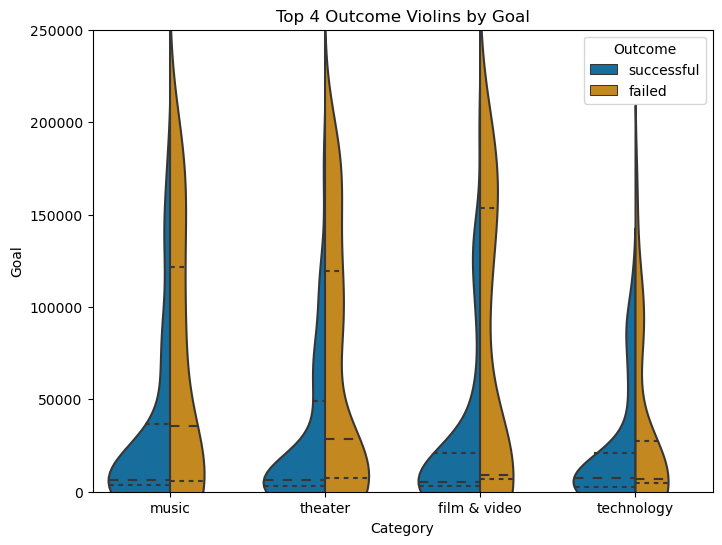

In [13]:
# Plot violins
plt.figure(figsize=(8, 6))
sns.violinplot(x="category", y="goal", hue="outcome", data=df, palette="colorblind", split=True, inner="quart", scale="count")
plt.title('Top 4 Outcome Violins by Goal')
plt.legend(title='Outcome')
plt.xlabel('Category')
plt.ylabel('Goal')
plt.ylim(0,250000)
plt.show()

# Question 4: What is the relationship of the outcome on common email domains?

In [14]:
# We need outcome from campaign
# AND email from contacts on the contact_id foreign key
# ORM query
query = session.query(
    Co.email,
    Camp.outcome
).join(
    Camp,
    Camp.contact_id == Co.contact_id
)

# fetch the results and put in dataframe
results = query.all()
df = pd.DataFrame(results)
df

,email,outcome
0,cecilia.velasco@rodrigues.fr,failed
1,mariana.ellis@rossi.org,successful
2,sofie.woods@riviere.com,successful
3,jeanette.iannotti@yahoo.com,failed
4,samuel.sorgatz@gmail.com,failed
...,...,...
995,whitney.noack@laboratorios.org,successful
996,gelsomina.migliaccio@junk.com,failed
997,evangelista.pereira@thompson-peterson.biz,canceled
998,gareth.comolli@tiscali.fr,failed


In [15]:
# regex to find gmail domains
p1 = "@gmail"
gmail = df[df["email"].str.contains(p1)]
gmail

,email,outcome
4,samuel.sorgatz@gmail.com,failed
38,jaqueline.wallace@gmail.com,successful
41,chad.turner@gmail.com,successful
52,tammy.ramazzotti@gmail.com,failed
57,raymond.solorzano@gmail.com,successful
...,...,...
967,lilija.charles@gmail.com,successful
970,sharon.diallo@gmail.com,failed
972,bernadette.wang@gmail.com,successful
985,mason.potter@gmail.com,failed


In [16]:
# numpy array and list comprehension for gmail
gmail_emails = np.arange(1,105)
gm_email = ["Gmail" for gmail_email in gmail_emails]
gm_outcome = gmail.outcome

# create new email dataframe for gmail
gmail_data = {
    "email": gm_email,
    "outcome": gm_outcome
}
gmail_df = pd.DataFrame(data=gmail_data)
gmail_df

,email,outcome
4,Gmail,failed
38,Gmail,successful
41,Gmail,successful
52,Gmail,failed
57,Gmail,successful
...,...,...
967,Gmail,successful
970,Gmail,failed
972,Gmail,successful
985,Gmail,failed


In [17]:
# regex to find yahoo domains
p2 = "@yahoo"
yahoo = df[df["email"].str.contains(p2)]
yahoo

,email,outcome
3,jeanette.iannotti@yahoo.com,failed
7,kayla.moon@yahoo.de,successful
13,lotti.morris@yahoo.co.uk,successful
30,sheila.goodwin@yahoo.com,successful
49,peter.vogt@yahoo.com,successful
...,...,...
926,graham.bajardi@yahoo.com,failed
932,kristi.grant@yahoo.co.uk,successful
934,gionata.hussain@yahoo.com,successful
981,ippazio.angulo@yahoo.com,successful


In [18]:
# numpy array and list comprehension for yahoo
yahoo_emails = np.arange(1,112)
yh_email = ["Yahoo" for yahoo_email in yahoo_emails]
yh_outcome = yahoo.outcome

# create new email dataframe for yahoo
yahoo_data = {
    "email": yh_email,
    "outcome": yh_outcome
}
yahoo_df = pd.DataFrame(data=yahoo_data)
yahoo_df

,email,outcome
3,Yahoo,failed
7,Yahoo,successful
13,Yahoo,successful
30,Yahoo,successful
49,Yahoo,successful
...,...,...
926,Yahoo,failed
932,Yahoo,successful
934,Yahoo,successful
981,Yahoo,successful


In [19]:
# regex to find hotmail domains
p3 = "@hotmail"
hotmail = df[df["email"].str.contains(p3)]
hotmail

,email,outcome
5,socorro.luna@hotmail.com,successful
28,ingeborg.alba@hotmail.com,successful
34,gian.long@hotmail.com,successful
50,nicholas.christian@hotmail.de,failed
58,flora.harris@hotmail.com.au,successful
...,...,...
975,elliott.herrmann@hotmail.com.au,successful
976,graziella.vidal@hotmail.com,successful
982,grace.kroker@hotmail.com,failed
986,aaron.anaya@hotmail.com.au,failed


In [20]:
# numpy array and list comprehension for hotmail
hotmail_emails = np.arange(1,120)
hm_email = ["Hotmail" for hotmail_email in hotmail_emails]
hm_outcome = hotmail.outcome

# create new email dataframe for hotmail
hotmail_data = {
    "email": hm_email,
    "outcome": hm_outcome
}
hotmail_df = pd.DataFrame(data=hotmail_data)
hotmail_df

,email,outcome
5,Hotmail,successful
28,Hotmail,successful
34,Hotmail,successful
50,Hotmail,failed
58,Hotmail,successful
...,...,...
975,Hotmail,successful
976,Hotmail,successful
982,Hotmail,failed
986,Hotmail,failed


In [21]:
# concatinate list of email dataframes
email_df = pd.concat([gmail_df, yahoo_df, hotmail_df], ignore_index=True)

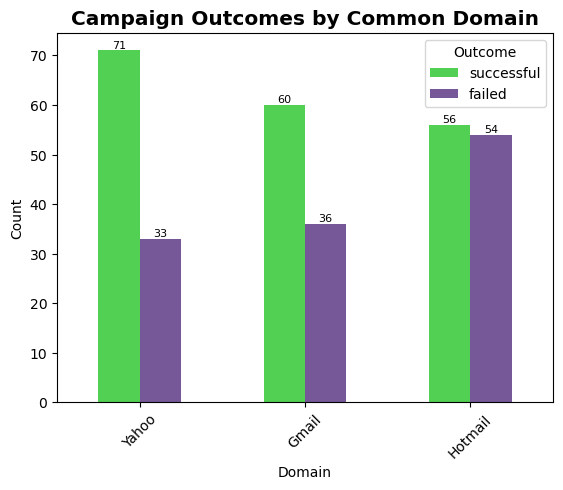

In [22]:
# Calculate total successful counts for each category and sort categories descending
pg = email_df.groupby(["email", "outcome"])["email"].count().unstack("outcome")
pg_sorted = pg.sort_values(by='successful', ascending=False)

# Plotting
ax = pg_sorted[["successful", "failed"]].plot(kind="bar", color=["#52d053", "#765898"])
plt.title("Campaign Outcomes by Common Domain", fontweight="bold", fontsize=14.5)
for container in ax.containers:
    ax.bar_label(container, size=8)
plt.legend(title='Outcome')
plt.xticks(rotation=45)
plt.xlabel("Domain")
plt.ylabel("Count")
plt.show()